In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import glob
import nibabel as nb
import itertools
import json
import sys
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder


%matplotlib inline

In [15]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [2]:
base_dir = '/home/abhijit/Jyotirmay/my_thesis'

sample_dir = f'{base_dir}/projects/hierarchical_quicknat/outs/hierarchical_quicknat_KORA_v2/hierarchical_quicknat_KORA_v2_predictions_KORA/*_samples/**'
mean_segs_dir = f'{base_dir}/projects/hierarchical_quicknat/outs/hierarchical_quicknat_KORA_v2/hierarchical_quicknat_KORA_v2_predictions_KORA/*_seg.nii.gz'
sample_paths = glob.glob(sample_dir)
mean_seg_paths = glob.glob(mean_segs_dir)
print(len(mean_seg_paths))
sample_paths.extend(mean_seg_paths)
print(len(sample_paths))

153
1683


In [3]:
sample_count_dict = {}
for r_id, sample in enumerate(sample_paths):
    print("\rProcessing {}/{}.".format(r_id, len(sample_paths)), end="")

    split_str = sample.split('/')[-1].split('.')[0]
    v_id = split_str.split('_')[0]
    sample_id = split_str.split('_')[-1]
    s_data = nb.load(sample).get_fdata()
    unique_vals, counts = np.unique(s_data, return_counts=True)
    if v_id not in sample_count_dict.keys():
        sample_count_dict[v_id] = {str(i)+'_spleen':None for i in range(10)}
        sample_count_dict[v_id].update({str(i)+'_liver':None for i in range(10)})
    if sample_id == 'seg':
        sample_count_dict[v_id]['seg_spleen'] = counts[2]
        sample_count_dict[v_id]['seg_liver'] = counts[1]
    else:
        sample_count_dict[v_id][str(sample_id)+'_liver'] = counts[2]    
        sample_count_dict[v_id][str(sample_id)+'_spleen'] = counts[1] 

print(sample_count_dict)
df = pd.DataFrame.from_dict(sample_count_dict, orient="index")
df.to_csv('./projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_sample_count_report.csv', index_label='volume_id')


Processing 1682/1683.{'KORA2452967': {'0_spleen': 12649, '1_spleen': 12657, '2_spleen': 12652, '3_spleen': 12662, '4_spleen': 12647, '5_spleen': 12680, '6_spleen': 12651, '7_spleen': 12661, '8_spleen': 12641, '9_spleen': 12650, '0_liver': 107825, '1_liver': 107890, '2_liver': 107925, '3_liver': 107865, '4_liver': 107909, '5_liver': 107827, '6_liver': 107890, '7_liver': 107880, '8_liver': 107896, '9_liver': 107836, 'seg_spleen': 107880, 'seg_liver': 12656}, 'KORA2459526': {'0_spleen': 20359, '1_spleen': 20345, '2_spleen': 20365, '3_spleen': 20346, '4_spleen': 20362, '5_spleen': 20373, '6_spleen': 20378, '7_spleen': 20364, '8_spleen': 20356, '9_spleen': 20379, '0_liver': 169591, '1_liver': 169568, '2_liver': 169594, '3_liver': 169564, '4_liver': 169553, '5_liver': 169594, '6_liver': 169563, '7_liver': 169565, '8_liver': 169637, '9_liver': 169544, 'seg_spleen': 169569, 'seg_liver': 20362}, 'KORA2455268': {'0_spleen': 6891, '1_spleen': 6889, '2_spleen': 6891, '3_spleen': 6896, '4_spleen': 

In [9]:
df = pd.read_csv('./projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_sample_count_report.csv')

In [10]:
df_k_feats = pd.read_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv.csv')
df_k_feats['volume_id'] = 'KORA' + df_k_feats['mrt-image-id'].astype(str)
df_k_feats.to_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv_.csv')

In [11]:
df_reports = pd.read_csv('./projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_report.csv')

In [12]:
df_merged = pd.merge(df, df_k_feats, how='inner', on=['volume_id'])
df_merged_final = pd.merge(df_merged, df_reports, how='inner', on=['volume_id'])
df_merged_final.to_csv('./projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_concat_report_final.csv')

In [13]:
df = pd.read_csv('./projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_concat_report_final.csv')

In [85]:
good_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
             'hba1c-mmol/mol', 'cholesterol-hdl', 'age', 'blood-pressure-diastolic', 'blood-pressure-systolic',
             'sex', 'bmi-numeric']

smoking_feats = ['smoker_former', 'smoker_irregular', 'smoker_non-smoker', 'smoker_regular', 'smoking-packages']
bmi_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
            'bmi-numeric', 'bmi-who_pre-obisety']
blood_pressure_feats = ['blood-pressure-diastolic', 'blood-pressure-systolic']
cholesterol_feats = ['cholesterol-hdl', 'cholesterol-ldl', 'cholesterol-total']
mri_feats = ['mri-liver-fat-artifacts', 'mri-liver-fat-lobus-dexter', 
             'mri-liver-fat-lobus-sinister', 'mri-liver-fat-portal-vein']
alcohol_feats = ['alcohol-g/day']
hbalc_feats = ['hba1c-mmol/mol', 'hba1c-percentage']
medication_feats = ['meds-antidiabetic', 'meds-antihypertensive', 'meds-incretin-mimetics', 'meds-insulin-therapy',
                    'meds-lipoprotein-lowering', 'meds-oral-antidiabetic']
triglyceride = ['triglyceride']
hypertension = ['hypertension']
basic_feats = ['age', 'height', 'sex', 'weight' ]
vols_feat = ['seg_liver', 'seg_spleen']



In [112]:
all_feats = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension, vols_feat]
feats = flatten(all_feats)
df = df.fillna(0)
p_values = {}
y = df["diabetes_status"].copy()
y_classes = np.argmax(pd.get_dummies(y).values, axis=1)
# print(y_classes, pd.get_dummies(y).values)
for f in feats:
    try:
        X = pd.get_dummies(df.loc[y.index, [f]], drop_first=True)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0])
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

[0 0 0 0 2 0 0 0 2 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 1 0 2 1 0 0 1
 1 1 0 0 0 0 0 0 0 1 1 0 0 2 0 2 2 0 0 0 0 0 0 2 0 2 0 2 1 0 1 1 1 0 0 0 0
 0 2 0 0 0 0 0 0 0 0 2 1 0 1 1 0 2 2 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0
 0 1 2 0 0 2 1 0 2 2 0 0 0 0 0 1 1 1 0 2 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 1 0] [[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 

,coeff,p_value
age,0.008857,1.232938e-15
height,0.002735,8.371145e-14
sex,0.615385,4.480111e-14
weight,0.006076,5.552860e-17
smoker_former,0.514706,1.934475e-07
smoker_irregular,0.333333,2.394919e-01
smoker_non-smoker,0.423077,2.523419e-04
smoker_regular,0.500000,3.555895e-03
smoking-packages,0.014308,1.977551e-05
bmi-who_normal,0.190476,1.460153e-01


In [20]:

p_value_df.to_csv('./projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_p_values.csv', index_label='feats')
        

In [114]:
categorical_features = ['diabetes_status']
for f in categorical_features:
    dfDummies = pd.get_dummies(df[f], prefix = f)
    df_c = pd.concat([df, dfDummies], axis=1)

,Unnamed: 0,volume_id,0_spleen,1_spleen,2_spleen,3_spleen,4_spleen,5_spleen,6_spleen,7_spleen,...,surface_distance_prtogt_mean,surface_distance_gttopr_spleen,surface_distance_gttopr_liver,surface_distance_gttopr_mean,surface_distance_avg_spleen,surface_distance_avg_liver,surface_distance_avg_mean,diabetes_status_0,diabetes_status_1,diabetes_status_2
0,0,KORA2452967,12649,12657,12652,12662,12647,12680,12651,12661,...,0.876236,0.907565,0.885131,0.896348,0.930961,0.841623,0.886292,1,0,0
1,1,KORA2459526,20359,20345,20365,20346,20362,20373,20378,20364,...,0.880185,0.885799,0.841958,0.863879,0.910439,0.833625,0.872032,1,0,0
2,2,KORA2455268,6891,6889,6891,6896,6896,6892,6883,6890,...,0.215515,0.165312,0.210575,0.187943,0.192045,0.211413,0.201729,1,0,0
3,3,KORA2454788,16244,16279,16287,16254,16254,16280,16268,16277,...,0.890549,0.860252,0.896426,0.878339,0.873524,0.895364,0.884444,1,0,0
4,4,KORA2453589,17916,17927,17918,17912,17908,17897,17907,17897,...,0.871548,0.922258,0.916209,0.919234,0.928819,0.861962,0.895391,0,0,1
5,5,KORA2456202,17363,17353,17368,17338,17350,17345,17367,17353,...,0.943204,0.965745,0.920338,0.943042,0.969144,0.917102,0.943123,1,0,0
6,6,KORA2459774,15324,15318,15307,15313,15297,15312,15297,15312,...,0.928370,0.990086,0.902638,0.946362,0.967801,0.906930,0.937366,1,0,0
7,7,KORA2459983,12726,12718,12718,12723,12729,12726,12726,12720,...,0.915530,0.961159,0.872522,0.916840,0.954361,0.878010,0.916185,1,0,0
8,8,KORA2452094,17146,17117,17114,17125,17139,17115,17123,17138,...,0.783715,0.882376,0.851695,0.867036,0.856191,0.794559,0.825375,0,0,1
9,9,KORA2460447,21784,21771,21778,21756,21761,21772,21762,21772,...,0.976121,0.995462,0.954977,0.975220,0.996208,0.955133,0.975670,0,1,0


In [116]:
all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension,
                  ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]

feats = flatten(all_feats4vols)
df_c = df_c.fillna(0)
p_values = {}
y = df_c["seg_spleen"].copy()
y_classes = y.values #np.argmax(pd.get_dummies(y).values, axis=1)
for f in feats:
    try:
        X = pd.get_dummies(df_c.loc[y.index, [f]], drop_first=True)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0], fii.params.values)
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)

# print(p_values)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

,coeff,p_value
age,2400.861815,8.499854e-79
height,806.703552,1.654727e-103
sex,150418.945055,3.800569e-38
weight,1653.224821,1.020902e-127
smoker_former,140776.161765,1.101893e-20
smoker_irregular,132843.111111,4.663286e-03
smoker_non-smoker,134755.576923,1.010317e-13
smoker_regular,139926.083333,5.646162e-07
smoking-packages,4148.496886,2.270101e-15
bmi-who_normal,114958.333333,4.225527e-08


In [118]:
all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension,
                  ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]

feats = flatten(all_feats4vols)
df_c = df_c.fillna(0)
p_values = {}
y = df_c["seg_liver"].copy()
y_classes = y.values #np.argmax(pd.get_dummies(y).values, axis=1)
for f in feats:
    try:
        X = pd.get_dummies(df_c.loc[y.index, [f]], drop_first=True)
#         print(X)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0], fii.params.values)
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)

# print(p_values)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

,coeff,p_value
age,287.380570,1.530796e-57
height,96.933943,1.143606e-68
sex,18337.197802,3.637452e-34
weight,199.515704,5.172259e-77
smoker_former,17773.514706,8.551827e-21
smoker_irregular,17285.333333,3.446138e-03
smoker_non-smoker,16126.365385,2.620340e-12
smoker_regular,13829.625000,1.128459e-04
smoking-packages,503.287514,3.823825e-14
bmi-who_normal,12248.571429,4.930717e-06


In [122]:
# all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
#              mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension, ['diabetes_status']]
all_feats_simple = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['height', 'weight']]
all_feats_simple1 = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['bmi-numeric']]
all_feats_simple2 = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['height', 'weight', 'bmi-numeric']]
all_feats_simple3 = [['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]
for feats_list in [all_feats_simple, all_feats_simple1, all_feats_simple2, all_feats_simple3]:
    feats = flatten(feats_list)
    df_c = df_c.fillna(0)
    p_values = {}
    for target in ['seg_liver', 'seg_spleen']:
        print(target)
        for i in range(2):
            
            y = df_c[target].copy()
    #         print(y.values)
    #         y_classes = np.argmax(pd.get_dummies(y).values, axis=1)
            y_classes = y.values
            if i==0:
                print('iou as multiplier')
                target_prefix = target.split('_')[1]
                ious = df_c['iou_'+target_prefix].values
#                 print(y_classes[0:10], ious[0:10])
                y_classes = np.multiply(y_classes, ious)
#                 print(y_classes[0:10])
    #         print(y_classes)
            try:
                X = pd.get_dummies(df_c.loc[y.index, feats], drop_first=True)
            #         X = X.fillna(0)
                mod = sm.OLS(y_classes, X)
                fii = mod.fit()
                print(fii.summary())
            #         print(f, fii.pvalues.values[0], fii.params.values)
                p_values[f] = {'coeff': fii.params.values, 'p_value':fii.pvalues.values}
            except Exception as e:
                print(e)

# print(p_values)
# p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
# p_value_df

seg_liver
iou as multiplier
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     10.36
Date:                Thu, 24 Oct 2019   Prob (F-statistic):           1.49e-09
Time:                        15:25:15   Log-Likelihood:                -1537.1
No. Observations:                 153   AIC:                             3088.
Df Residuals:                     146   BIC:                             3110.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
age       

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     9.144
Date:                Thu, 24 Oct 2019   Prob (F-statistic):           2.46e-09
Time:                        15:25:16   Log-Likelihood:                -1538.4
No. Observations:                 153   AIC:                             3093.
Df Residuals:                     145   BIC:                             3117.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                 -55.2302     59.53

In [41]:
df_normal = df[df['diabetes_status']==0]
df_pre_diabetic = df[df['diabetes_status']==1]
df_diabetic = df[df['diabetes_status']==2]

Text(0, 0.5, 'Dice Score')

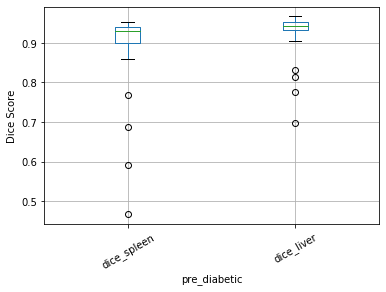

In [23]:
boxplot = df_pre_diabetic[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("pre_diabetic")
boxplot.set_ylabel("Dice Score")

Text(0, 0.5, 'Dice Score')

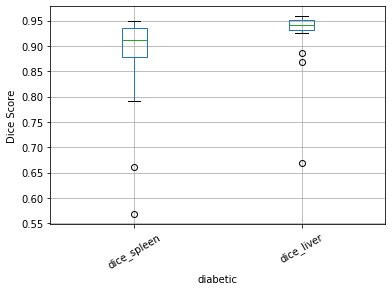

In [24]:
boxplot = df_diabetic[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("diabetic")
boxplot.set_ylabel("Dice Score")

Text(0, 0.5, 'Dice Score')

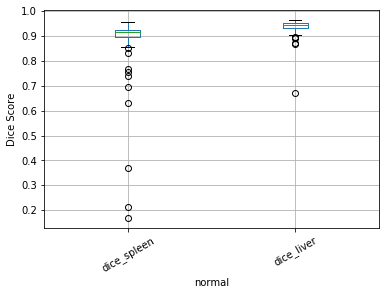

In [25]:
boxplot = df_normal[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("normal")
boxplot.set_ylabel("Dice Score")

/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


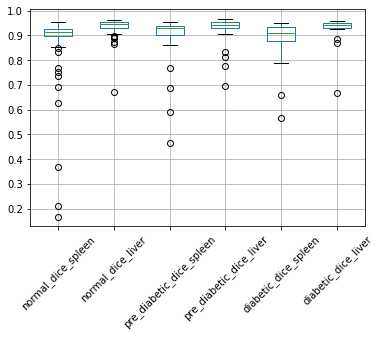

In [44]:

df_normal_affx = df_normal.rename(columns=lambda x: 'normal_'+x)
df_pre_diabetic_affx = df_pre_diabetic.rename(columns=lambda x: 'pre_diabetic_'+x)
df_diabetic_affx = df_diabetic.rename(columns=lambda x: 'diabetic_'+x)
dfs = pd.concat([df_normal_affx, df_pre_diabetic_affx, df_diabetic_affx])
fig, ax1 = plt.subplots()
dfs[['normal_dice_spleen', 'normal_dice_liver', 'pre_diabetic_dice_spleen', 'pre_diabetic_dice_liver', 'diabetic_dice_spleen', 'diabetic_dice_liver']].boxplot(rot=45)

# ax2 = ax1.twinx()
# df_pre_diabetic_affx[['pre_diabetic_dice_spleen', 'pre_diabetic_dice_liver']].boxplot()

# ax3 = ax1.twinx()
# df_diabetic_affx[['diabetic_dice_spleen', 'diabetic_dice_liver']].boxplot()

plt.show()

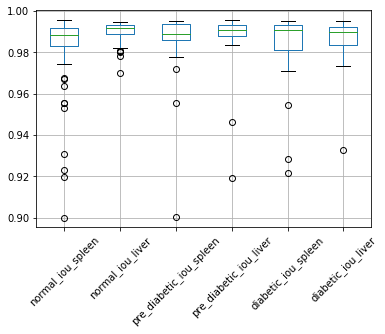

In [45]:
dfs[['normal_iou_spleen', 'normal_iou_liver', 'pre_diabetic_iou_spleen', 'pre_diabetic_iou_liver', 'diabetic_iou_spleen', 'diabetic_iou_liver']].boxplot(rot=45)


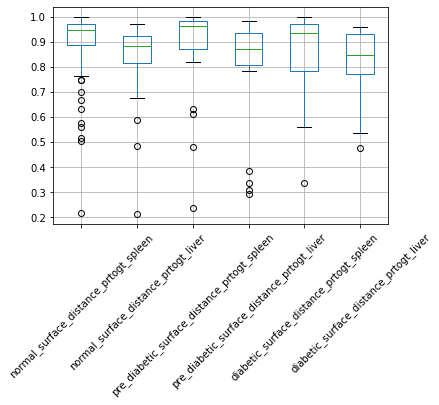

In [46]:
dfs[['normal_surface_distance_prtogt_spleen', 'normal_surface_distance_prtogt_liver', 'pre_diabetic_surface_distance_prtogt_spleen', 'pre_diabetic_surface_distance_prtogt_liver', 'diabetic_surface_distance_prtogt_spleen', 'diabetic_surface_distance_prtogt_liver']].boxplot(rot=45)


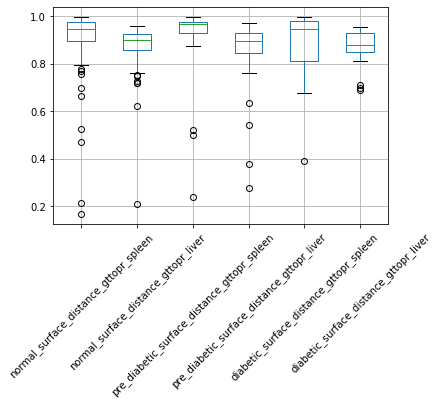

In [47]:
dfs[['normal_surface_distance_gttopr_spleen', 'normal_surface_distance_gttopr_liver', 'pre_diabetic_surface_distance_gttopr_spleen', 'pre_diabetic_surface_distance_gttopr_liver', 'diabetic_surface_distance_gttopr_spleen', 'diabetic_surface_distance_gttopr_liver']].boxplot(rot=45)


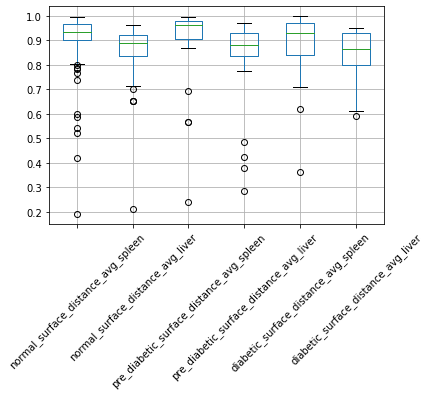

In [48]:
dfs[['normal_surface_distance_avg_spleen', 'normal_surface_distance_avg_liver', 'pre_diabetic_surface_distance_avg_spleen', 'pre_diabetic_surface_distance_avg_liver', 'diabetic_surface_distance_avg_spleen', 'diabetic_surface_distance_avg_liver']].boxplot(rot=45)


0.670495799490242
0.5038631414392785


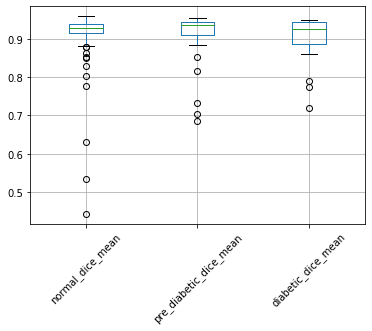

In [64]:
# dfs[['normal_iou_mean', 'normal_dice_mean', 'pre_diabetic_iou_mean', 'pre_diabetic_dice_mean', 'diabetic_iou_mean', 'diabetic_dice_mean']].boxplot(rot=45)
dfs[[ 'normal_dice_mean', 'pre_diabetic_dice_mean', 'diabetic_dice_mean']].boxplot(rot=45)

# dfs['normal_dice_mean'].dropna().values


t,p = stats.ttest_ind(dfs['normal_dice_mean'].dropna().values, dfs[ 'diabetic_dice_mean'].dropna().values)

print(t)
print(p)

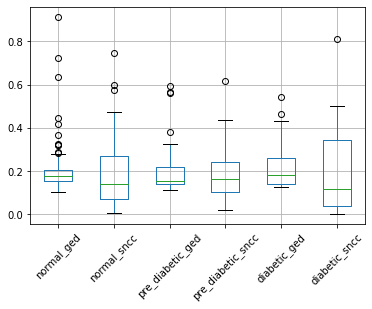

In [50]:
dfs[['normal_ged', 'normal_sncc', 'pre_diabetic_ged', 'pre_diabetic_sncc', 'diabetic_ged', 'diabetic_sncc']].boxplot(rot=45)


normal_seg_spleen vs pre_diabetic_seg_spleen
t: -3.48232272284658
p: 0.0006746073067002347


normal_seg_spleen vs diabetic_seg_spleen
t: -4.882538380676389
p: 3.348126093061215e-06


diabetic_seg_spleen vs pre_diabetic_seg_spleen
t: 1.6872168841875226
p: 0.09766960436389012


normal_seg_liver vs pre_diabetic_seg_liver
t: -1.396650554294875
p: 0.1648625640501467


normal_seg_liver vs diabetic_seg_liver
t: -1.1831585605461927
p: 0.2391448536459703


diabetic_seg_liver vs pre_diabetic_seg_liver
t: 0.10754103198172134
p: 0.9147817306969075




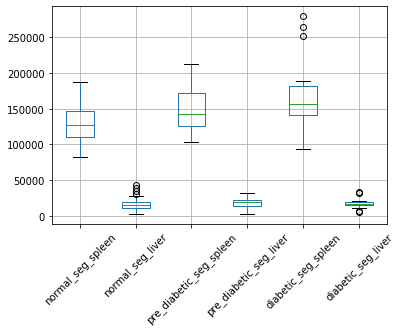

In [72]:
dfs[['normal_seg_spleen', 'normal_seg_liver', 'pre_diabetic_seg_spleen', 'pre_diabetic_seg_liver', 'diabetic_seg_spleen', 'diabetic_seg_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)

print('normal_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'diabetic_seg_spleen'].dropna().values)
print('normal_seg_spleen vs diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)
print('diabetic_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('diabetic_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')